In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import numpy as np
import pandas as pd
import seaborn as sn
%matplotlib inline
import matplotlib.pyplot as plt
import datetime
import wbdata as wb
from datetime import timedelta, date
from pandas_datareader import data
pd.options.display.float_format = '{:.2f}'.format

In [ ]:
!pip install wbdata

In [19]:
stock = {'GFDD.OM.02': 'Global Financial Development'}
im = {'SM.POP.NETM': 'Population estimates and projections'}

In [20]:
#Define the instruments to download. We would like to see Apple, Microsoft and the S&P500 index.
tickers = ['AAPL', 'MSFT', 'NFLX']

# Define which online source one should use
data_source = 'yahoo'

# We would like all available data from 01/01/2000 until 12/31/2016.
start_date = '2004-01-01'
end_date = '2018-03-21'

# User pandas_reader.data.DataReader to load the desired data. As simple as that.
panel_data = data.DataReader(tickers, data_source, start_date, end_date)

In [21]:
Stock_data=panel_data.to_frame
from pandas_datareader import DataReader
def get(tickers, startdate, enddate):
  stock=DataReader(tickers,'yahoo',start=startdate,end=enddate)
  return stock

###### Get Google stock, based on Mountain View

In [22]:
Google = get('GOOGL','1-1-2005',datetime.date.today())

# Use only Close Price
Google = Google.loc[:,['Close']]

# Resample stock price monthly
Google=Google.resample('M').mean()

# Rename column
Google=Google.rename(columns={'Close':'Google'})
Google.head()

,Google
Date,
2005-01-31,96.52
2005-02-28,97.60
2005-03-31,90.67
2005-04-30,99.71
2005-05-31,119.97


# Time Seies Prediction

Time Series case is special because of two properties:
1. It is time dependent. So the basic assumption of a linear regression model doesn’t hold in this case.
2. Along with an increasing or decreasing trend, most TS have some form of seasonality trends.

In [23]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [24]:
# To start a TS (time series) case, we have to convert the index type to datetime
GG = Google.copy()
GG.index = pd.to_datetime(GG.index)
GG.index.name = 'Time'
GG.head()

,Google
Time,
2005-01-31,96.52
2005-02-28,97.60
2005-03-31,90.67
2005-04-30,99.71
2005-05-31,119.97


In [25]:
gg = GG['Google']
gg.head()

Time
2005-01-31    96.52
2005-02-28    97.60
2005-03-31    90.67
2005-04-30    99.71
2005-05-31   119.97
Freq: M, Name: Google, dtype: float64

### Check Stationarity of a Time Series

"Most of the TS models work on the assumption that the TS is stationary. A TS is said to be stationary if its statistical properties such as mean, variance remain constant over time

we can assume the series to be stationary if it has constant statistical properties over time, ie. the following:

1. constant mean
2. constant variance
3. an autocovariance that does not depend on time."

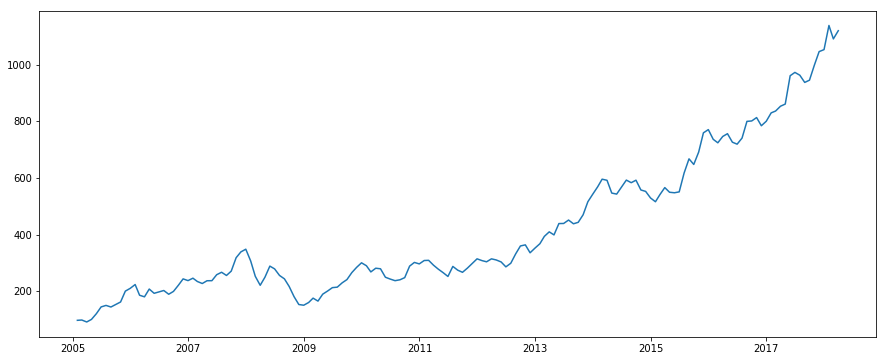

In [27]:
plt.plot(gg);

From the graph above we can find it's not a very clear TS and with an overall increasing trend. In this case, we can check  stationarity using the following:

1. Plotting Rolling Statistics: Plot the moving average or moving variance and see if it varies with time.

2. Dickey-Fuller Test: This is one of the statistical tests for checking stationarity. 

In [ ]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    # Calculate rolling statistics
    rolmean = pd.Series.rolling(timeseries, window=12,center=False).mean()
    rolstd = pd.Series.rolling(timeseries, window=12,center=False).std()

    # Plot rolling statistics in one graph:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
   # Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    test = adfuller(timeseries, autolag='AIC')
    output = pd.Series(test[0:2], index=['Test Statistic','p-value'])
    for key,value in test[4].items():
        output['Critical Value (%s)'%key] = value
    print (output)

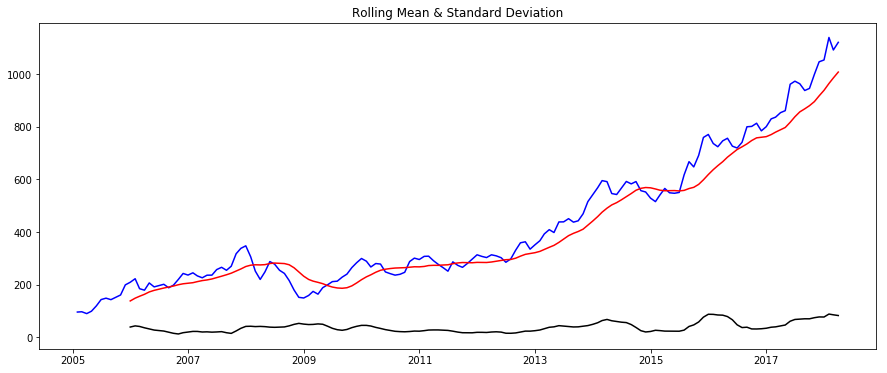

Results of Dickey-Fuller Test:
Test Statistic          2.29
p-value                 1.00
Critical Value (1%)    -3.47
Critical Value (5%)    -2.88
Critical Value (10%)   -2.58
dtype: float64


In [29]:
test_stationarity(gg)

From the test result above, we can find that this is not a stationary series, due to two reasons:
1. Despite its low variation in standard deviation, the mean is clearly increasing with time, then it is not stationary.
2. Test statistic is far more than any Critical Value, only if the 'Test Statistic' is less than the 'Critical Value', we can reject the null hypothesis and say that the series is stationary. 

### Make the TS stationary

Before re-create the TS to a stationary one, we should be aware of reasons that make it unstationary:
1. Trend – varying mean over time. As we saw in this case, the stock price mean was growing over time.
2. Seasonality – variations at specific time-frames. eg stock market has the tradition to go down during Christmas

Solution here is to estimate the trend and seasonality in the series and remove those from the series to get a stationary series

##### Solution 1 - Use log transformation

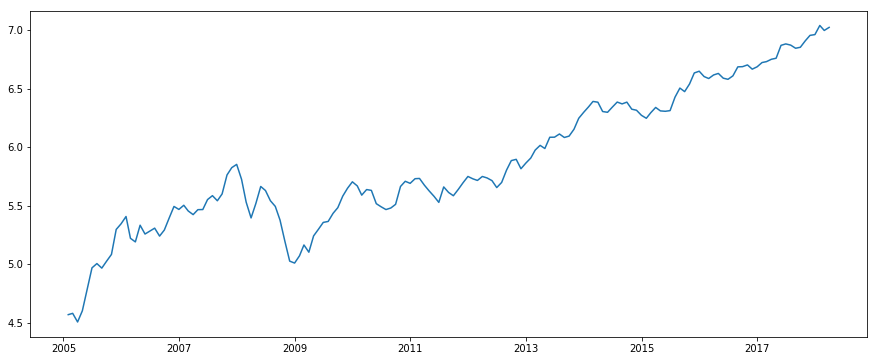

In [32]:
gg_log = np.log(gg)
plt.plot(gg_log);

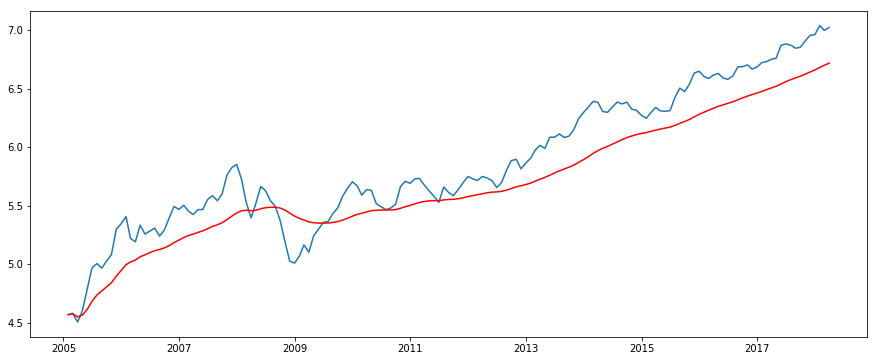

In [33]:
# Assign weight to more recent values by taking exponentially weighted moving average
expwighted_mean = pd.Series.ewm(gg_log, halflife=12).mean() # 'halflife' here is used to define the amount of exponential decay
plt.plot(gg_log);
plt.plot(expwighted_mean, color='red');

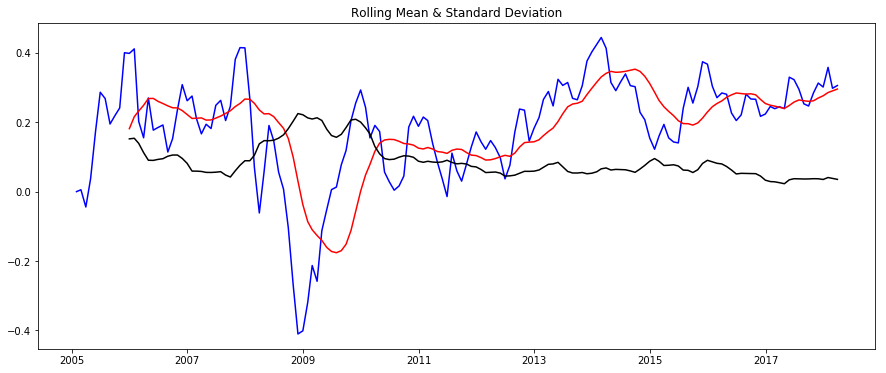

Results of Dickey-Fuller Test:
Test Statistic         -3.41
p-value                 0.01
Critical Value (1%)    -3.47
Critical Value (5%)    -2.88
Critical Value (10%)   -2.58
dtype: float64


In [35]:
# Test result of exponentially weighted moving average
gg_log_ewma_diff = gg_log - expwighted_mean
test_stationarity(gg_log_ewma_diff)

From the test statistic result above, we can find that it is smaller than 5% Critical Value, thus the TS is stationary with 95% confidence.

"Note: in this case there will be no missing values as all values from starting are given weights. So it’ll work even with no previous values."

##### Solution 2 - Differencing

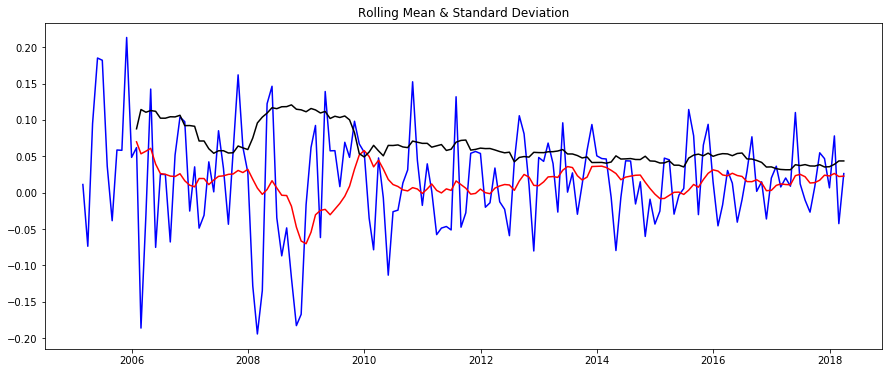

Results of Dickey-Fuller Test:
Test Statistic         -8.80
p-value                 0.00
Critical Value (1%)    -3.47
Critical Value (5%)    -2.88
Critical Value (10%)   -2.58
dtype: float64


In [37]:
# Calculate between each log value
gg_log_diff = gg_log - gg_log.shift()
gg_log_diff.dropna(inplace=True)

# Test result of difference
test_stationarity(gg_log_diff)

From the result above , we can find the Dickey-Fuller test statistic is greatly less than the 1% critical value, thus the TS is stationary with 99% confidence. So this TS is very close to stationary and is better than the one above.

### Forecasting a Time Series

"Since this series is with significant dependence among values. In this case we need to use ARIMA model to forecast the data.

ARIMA forecasting for a stationary time series is a linear equation, whose predictors depend on the parameters (p,d,q) of the ARIMA model:

1. Number of AR (Auto-Regressive) terms (p): AR terms are just lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).
2. Number of MA (Moving Average) terms (q): MA terms are lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.
3. Number of Differences (d): These are the number of nonseasonal differences."

##### Determine the value of 'p' and 'q'

"
1. Autocorrelation Function (ACF): It is a measure of the correlation between the the TS with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’t2’ with series at instant ‘t1-5’…’t2-5’ (t1-5 and t2 being end points).
2. Partial Autocorrelation Function (PACF): This measures the correlation between the TS with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons. Eg at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4."

In [38]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

In [39]:
lag_acf = acf(gg_log_diff, nlags=20)
lag_pacf = pacf(gg_log_diff, nlags=20, method='ols')

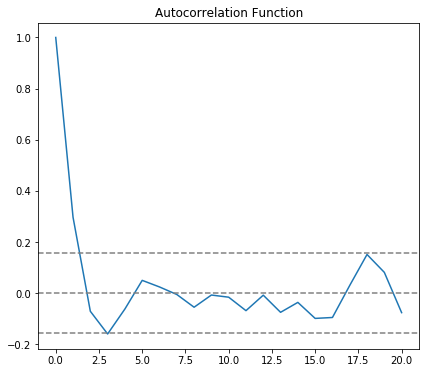

In [40]:
#Plot ACF: 
plt.subplot(121); 
plt.plot(lag_acf);

# Make confidence intervals on either sides of 0, which are used to determine the 'p' and 'q' values
plt.axhline(y=0,linestyle='--',color='gray');
plt.axhline(y=-1.96/np.sqrt(len(gg_log_diff)),linestyle='--',color='gray');
plt.axhline(y=1.96/np.sqrt(len(gg_log_diff)),linestyle='--',color='gray');

# Rename plot graph
plt.title('Autocorrelation Function');

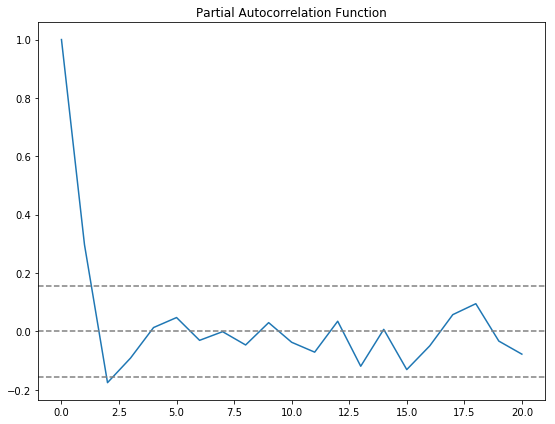

In [42]:
#Plot PACF:
plt.subplot(122);
plt.plot(lag_pacf);

# Make confidence intervals on either sides of 0, which are used to determine the 'p' and 'q' values
plt.axhline(y=0,linestyle='--',color='gray');
plt.axhline(y=-1.96/np.sqrt(len(gg_log_diff)),linestyle='--',color='gray');
plt.axhline(y=1.96/np.sqrt(len(gg_log_diff)),linestyle='--',color='gray');

# Rename plot graph
plt.title('Partial Autocorrelation Function');
plt.tight_layout();

From the result above, we can know that:
1. p – The lag value where the PACF chart crosses the upper confidence interval for the first time, in this case p=2.
2. q – The lag value where the ACF chart crosses the upper confidence interval for the first time, in this case q=2.

In [43]:
# Load the ARIMA model
from statsmodels.tsa.arima_model import ARIMA

Module One: AR Model

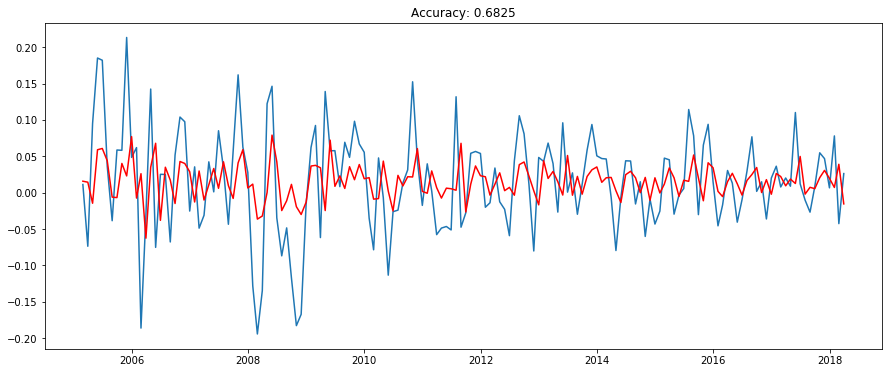

In [45]:
model = ARIMA(gg_log, order=(2, 1, 0)) # use the order argument to decide p,d,q values of ARIMA model
results_AR = model.fit(disp=-1)  
plt.plot(gg_log_diff);
plt.plot(results_AR.fittedvalues, color='red');
plt.title('Accuracy: %.4f'% sum((results_AR.fittedvalues-gg_log_diff)**2)); 

Module Two: MA Model

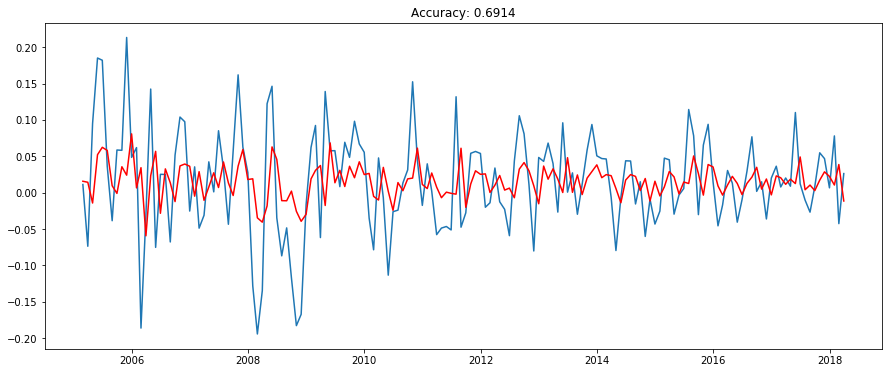

In [46]:
model = ARIMA(gg_log, order=(0, 1, 2)) # use the order argument to decide p,d,q values of ARIMA model
results_MA = model.fit(disp=-1)  
plt.plot(gg_log_diff);
plt.plot(results_MA.fittedvalues, color='red');
plt.title('Accuracy: %.4f'% sum((results_MA.fittedvalues-gg_log_diff)**2));  

Module Three: Combined Model

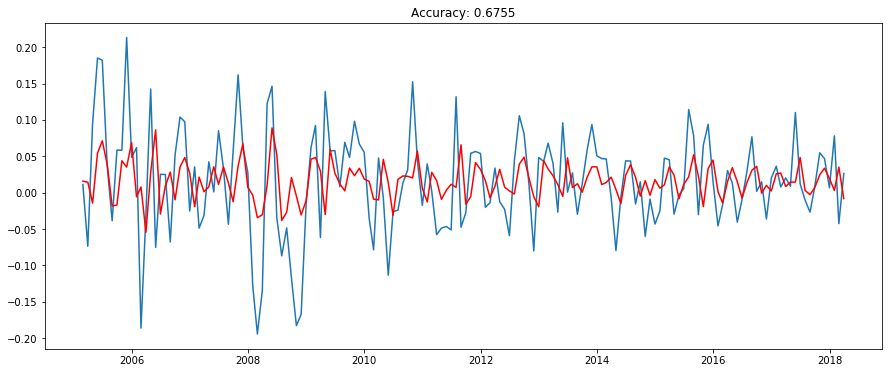

In [48]:
model = ARIMA(gg_log, order=(2, 1, 2))  # use the order argument to decide p,d,q values of ARIMA model
results_Comb = model.fit(disp=-1)  
plt.plot(gg_log_diff);
plt.plot(results_Comb.fittedvalues, color='red');
plt.title('Accuracy: %.4f'% sum((results_Comb.fittedvalues-gg_log_diff)**2));

From the Accuracy results above, we can find that the combined module is a little better than the other two, so let's use this module later

### Take it back to original scale

Store predcited results first

In [49]:
pred_Comb_diff = pd.Series(results_Comb.fittedvalues, copy=True)
print (pred_Comb_diff.tail())

Time
2017-11-30    0.03
2017-12-31    0.02
2018-01-31    0.00
2018-02-28    0.04
2018-03-31   -0.01
Freq: M, dtype: float64


In [50]:
# Convert the differencing to log scale
pred_Comb_diff_cumsum = pred_Comb_diff.cumsum()
print (pred_Comb_diff_cumsum.tail())

Time
2017-11-30   2.43
2017-12-31   2.44
2018-01-31   2.45
2018-02-28   2.48
2018-03-31   2.47
Freq: M, dtype: float64


In [51]:
# Add them back to dataset number
pred_Comb_log = pd.Series(gg_log.iloc[0], index=gg_log.index)
pred_Comb_log = pred_Comb_log.add(pred_Comb_diff_cumsum,fill_value=0)
pred_Comb_log.tail()

Time
2017-11-30   6.99
2017-12-31   7.01
2018-01-31   7.02
2018-02-28   7.05
2018-03-31   7.04
Freq: M, dtype: float64

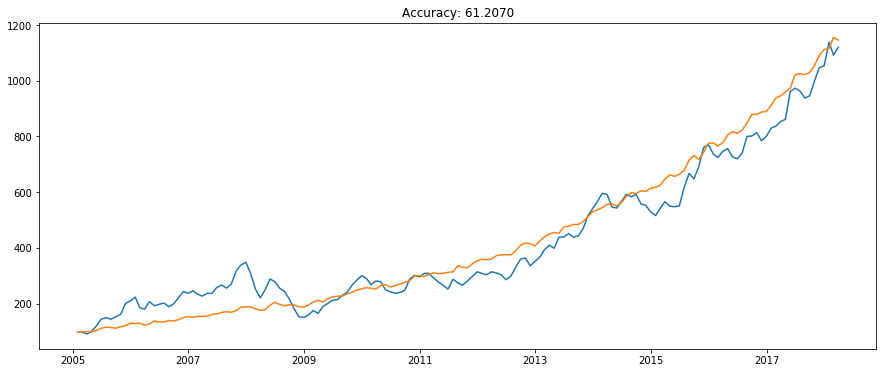

In [52]:
# Compare the predicted module with the actual one
pred_Comb = np.exp(pred_Comb_log)
plt.plot(gg);
plt.plot(pred_Comb);
plt.title('Accuracy: %.4f'% np.sqrt(sum((pred_Comb-gg)**2)/len(gg)));

From the graph above, we can find the result is pretty close to the actual line, so our model can work in some extent

### Reference(content in " " are quoted online):  
### https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
### http://pandas.pydata.org/pandas-docs/stable/computation.html#exponentially-weighted-moment-functions
### https://www.analyticsvidhya.com/blog/2015/12/complete-tutorial-time-series-modeling/